# Predicting Hypertension Using NHANES Data

## 1. EDA

### 1.1 Data Cleaning and Rough Selection of Features

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

exam_data = pd.read_csv('data/examination.csv')
diet_data = pd.read_csv('data/diet.csv')
demo_data = pd.read_csv('data/demographic.csv')

print(
    f"examination.csv: shape {exam_data.shape}, number of null values {exam_data.isnull().sum().sum()}")
print(
    f"diet.csv: shape {diet_data.shape}, number of null values {diet_data.isnull().sum().sum()}")
print(
    f"demographic.csv: shape {demo_data.shape}, number of null values {demo_data.isnull().sum().sum()}")

examination.csv: shape (9813, 224), number of null values 1014981
diet.csv: shape (9813, 168), number of null values 704978
demographic.csv: shape (10175, 47), number of null values 82092


From the shape of the data it can be seen that there is an excessive number of features in the data sets, and there are considerable missing values. It means we have to first drop some row or columns base on the number of missing values in it. Then we could roughly select features based on the correleation with blood pressure data.

#### 1.1.1 Blood pressure label cleaning

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Processing blood pressure data
data = pd.read_csv('data/examination.csv')
data_pressure = data[['SEQN', 'BPXDI1', 'BPXDI2', 'BPXDI3',
                      'BPXDI4', 'BPXSY1', 'BPXSY2', 'BPXSY3', 'BPXSY4']].copy()

for column in ['BPXDI1', 'BPXDI2', 'BPXDI3', 'BPXDI4']:
    data_pressure[column] = data_pressure[column].apply(
        lambda x: [x] if 30 < x < 200 else [])

for column in ['BPXSY1', 'BPXSY2', 'BPXSY3', 'BPXSY4']:
    data_pressure[column] = data_pressure[column].apply(
        lambda x: [x] if 50 < x < 250 else [])

data_pressure['Diastolic'] = data_pressure['BPXDI1'] + \
    data_pressure['BPXDI2'] + data_pressure['BPXDI3'] + data_pressure['BPXDI4']
data_pressure['Systolic'] = data_pressure['BPXSY1'] + \
    data_pressure['BPXSY2'] + data_pressure['BPXSY3'] + data_pressure['BPXSY4']

data_pressure['Diastolic'] = data_pressure['Diastolic'].apply(
    lambda x: np.mean(x) if len(x) > 0 else np.NaN)
data_pressure['Systolic'] = data_pressure['Systolic'].apply(
    lambda x: np.mean(x) if len(x) > 0 else np.NaN)

data_pressure = data_pressure[[
    'SEQN', 'Diastolic', 'Systolic']].dropna(how='any')
data_pressure['SEQN'] = data_pressure['SEQN'].astype(int)
df = data_pressure.copy()

In [3]:
# Categorize blood pressure based on the range provided in hw1. Normal and elevated blood pressure are combined into one category
normal = df[(df['Diastolic'] < 80) & (df['Systolic'] < 130)].copy()
s1_hyper = df[((df['Diastolic'] >= 80) & (df['Diastolic'] < 90) & (df['Systolic'] < 140)) |
              ((df['Systolic'] >= 130) & (df['Systolic'] < 140) & (df['Diastolic'] < 90))].copy()
s2_hyper = df[((df['Diastolic'] >= 90) & (df['Diastolic'] < 120) & (df['Systolic'] < 180)) |
              ((df['Systolic'] >= 140) & (df['Systolic'] < 180) & (df['Diastolic'] < 120))].copy()

normal['blood_pressure'] = 'normal'
s1_hyper['blood_pressure'] = 'stage 1 hypertension'
s2_hyper['blood_pressure'] = 'stage 2 hypertension'

blood_pressure = pd.concat([normal, s1_hyper, s2_hyper]).sort_values(
    by='SEQN').set_index('SEQN')
display(blood_pressure['blood_pressure'].value_counts())
blood_pressure.info()

blood_pressure
normal                  5461
stage 1 hypertension    1075
stage 2 hypertension     881
Name: count, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Index: 7417 entries, 73557 to 83731
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Diastolic       7417 non-null   float64
 1   Systolic        7417 non-null   float64
 2   blood_pressure  7417 non-null   object 
dtypes: float64(2), object(1)
memory usage: 202.8+ KB


Our objective is to estimate whether a person will be tested as hypertension. We use the principle of gathering all tests and taking average of what we have to increase precision and decrease the rows we need to drop.

In [4]:
def num_cat(df, threshold=10):
    numerical = []
    categorical = []

    for column in df.columns:
        if df[column].nunique() > threshold:
            numerical.append(column)
        else:
            categorical.append(column)

    return numerical, categorical

Since many categorical values are recorded as floats we have to create a function to judge whether the feature is categorical or numerical. Givign the row number of 7417, we set the default threshold of 10, which means that if the number of unique values in the column is less or equal than 10, we regard the column as categorical. In special cases where the categorical variables have many values, we might adjust the threshold.

#### 1.1.2 Exam data cleaning

In [5]:
import math
exam = pd.merge(
    left=blood_pressure,
    right=data,
    how='left',
    on='SEQN'
)

# take average of some data
for column in ['MGXH1T1', 'MGXH1T2', 'MGXH1T3']:
    exam[column] = exam[column].apply(
        lambda x: [] if math.isnan(x) else [float(x)])
exam['MGXH1AVE'] = exam['MGXH1T1']+exam['MGXH1T2']+exam['MGXH1T3']
exam['MGXH1AVE'] = exam['MGXH1AVE'].apply(
    lambda x: np.mean(x) if len(x) > 0 else np.NaN)
for column in ['MGXH2T1', 'MGXH2T2', 'MGXH2T3']:
    exam[column] = exam[column].apply(
        lambda x: [] if math.isnan(x) else [float(x)])
exam['MGXH2AVE'] = exam['MGXH2T1']+exam['MGXH2T2']+exam['MGXH2T3']
exam['MGXH2AVE'] = exam['MGXH2AVE'].apply(
    lambda x: np.mean(x) if len(x) > 0 else np.NaN)

exam.drop(columns=['MGXH1T1', 'MGXH1T2', 'MGXH1T3', 'MGXH2T1', 'MGXH2T2',
          'MGXH2T3', 'BMXSAD1', 'BMXSAD2', 'BMXSAD3', 'BMXSAD4'], inplace=True)

We use the method similar to that used to obtain averge blood pressure.

In [6]:
# drop columns with too many missing values or only one value
from sklearn.impute import SimpleImputer
for column in exam.columns:
    if exam[column].isnull().sum() > 500:
        exam = exam.drop(column, axis=1)
    elif len(exam[column].value_counts()) < 2:
        exam = exam.drop(column, axis=1)

# fill missing values
exam.drop(columns=['BPXDI1', 'BPXDI2', 'BPXDI3',
          'BPXSY1', 'BPXSY2', 'BPXSY3'], inplace=True)
numerical, categorical = num_cat(exam, 15)
for col in categorical:
    exam[[col]] = SimpleImputer(
        strategy='most_frequent').fit_transform(exam[[col]])
for col in numerical:
    exam[[col]] = SimpleImputer(strategy='median').fit_transform(exam[[col]])

Base on the judgement function we wrote, we apply most frequent value for categorical variables and median for numerical variables.

In [7]:
# rough selection of features with acceptable correlation
exam_mapped = exam.copy()
for col in exam_mapped.columns:
    if col.startswith('OHX'):
        exam_mapped.drop(columns=[col], inplace=True)
exam_mapped = exam_mapped.drop(columns=['blood_pressure']).astype(float)
corr1 = exam_mapped.corr()['Diastolic'].sort_values(
    ascending=False, key=lambda x: abs(x))
corr2 = exam_mapped.corr()['Systolic'].sort_values(
    ascending=False, key=lambda x: abs(x))
columns = list(set(corr1[abs(corr1) > 0.05].index.to_list(
) + corr2[abs(corr2) > 0.05].index.to_list())-set(['Diastolic', 'Systolic', 'blood_pressure']))
columns = ['SEQN'] + columns
df_exam = exam[columns].copy()
exam_numerical, exam_categorical = num_cat(df_exam)
exam_numerical.remove('SEQN')
print(f'numerical features in exam: {exam_numerical}')
print(f'categrical features in exam: {exam_categorical}')

numerical features in exam: ['MGDCGSZ', 'BMXHT', 'BMXWAIST', 'MGXH1AVE', 'MGXH2AVE', 'BMXLEG', 'PEASCTM1', 'BPXPLS', 'BMXARML', 'BMXWT', 'BMXARMC', 'BMDAVSAD', 'BMXBMI', 'BPXML1']
categrical features in exam: ['MGQ070', 'BPAEN2', 'OHDDESTS', 'MGDEXSTS', 'BPAEN3', 'BPXPULS', 'MGQ100', 'BPACSZ', 'OHDEXSTS']


We roughly select the feature where the correlation with diastolic or systolic pressure is more than 0.05.

#### 1.1.3 Demographic data cleaning

In [8]:
demographics = pd.read_csv("data/demographic.csv")
bp = blood_pressure.copy()

# drop columns with too many missing values
for column in demographics.columns:
    if demographics[column].isnull().sum() > 1000:
        demographics.drop(column, axis=1, inplace=True)
constant_columns = [
    col for col in demographics.columns if demographics[col].nunique() == 1]
demographics.drop(columns=constant_columns, inplace=True)
demographics.drop(columns=['RIDSTATR'], inplace=True)
merge1 = pd.merge(bp, demographics, on='SEQN', how='left')

In [9]:
# fill missing values
from sklearn.impute import SimpleImputer
numerical, categorical = num_cat(merge1)
numerical_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')
merge1[numerical] = numerical_imputer.fit_transform(merge1[numerical])
merge1[categorical] = categorical_imputer.fit_transform(merge1[categorical])

In [10]:
# rough selection of features with acceptable correlation
merge1_eda = merge1.copy()
dcit_map = {"normal": 1, "elevated": 2,
            "stage 1 hypertension": 3, "stage 2 hypertension": 4}
merge1_eda['bp'] = merge1_eda['blood_pressure'].map(dcit_map)
merge1_eda.drop(columns=['SEQN', 'blood_pressure'], inplace=True)
merge1_corr1 = merge1_eda.corr()['Diastolic'].sort_values(
    ascending=False, key=lambda x: abs(x))
merge1_corr2 = merge1_eda.corr()['Systolic'].sort_values(
    ascending=False, key=lambda x: abs(x))
merge1_columns = list(set(merge1_corr1[abs(merge1_corr1) > 0.05].index.to_list(
) + merge1_corr2[abs(merge1_corr2) > 0.05].index.to_list())-set(['Diastolic', 'Systolic', 'bp']))
merge1_columns = ['SEQN'] + merge1_columns
df_demo = merge1[merge1_columns]
demo_num_list, demo_cate_list = num_cat(df_demo)
demo_num_list.remove('SEQN')
print(f'numerical features in demo: {demo_num_list}')
print(f'categrical features in demo: {demo_cate_list}')

numerical features in demo: ['RIDAGEYR', 'WTMEC2YR', 'DMDHRAGE', 'WTINT2YR', 'INDFMPIR']
categrical features in demo: ['DMDHHSIZ', 'RIAGENDR', 'SIAPROXY', 'DMDHRGND', 'DMDHHSZB', 'DMDHHSZE', 'DMDFMSIZ', 'DMDHREDU', 'DMDHHSZA']


### 1.1.4 Diet data cleaning

In [11]:
diet = pd.read_csv("data/diet.csv")
# drop empty rows
diet = diet[diet.WTDRD1 != 0]
diet.drop(columns=['DR1HELPD'])
# drop columns with too many missing values
for column in diet.columns:
    if diet[column].isnull().sum() > 500:
        diet.drop(column, axis=1, inplace=True)
# drop columns with constant values
constant_columns = [col for col in diet.columns if diet[col].nunique() == 1]
diet.drop(columns=constant_columns, inplace=True)

In [12]:
# fill missing values
merge2 = pd.merge(bp, diet, on='SEQN', how='left')
numerical, categorical = num_cat(merge2)
numerical_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')
merge2[numerical] = numerical_imputer.fit_transform(merge2[numerical])
merge2[categorical] = categorical_imputer.fit_transform(merge2[categorical])

In [13]:
# rough selection of features with acceptable correlation
merge2_eda = merge2.copy()
dcit_map = {"normal": 1, "elevated": 2,
            "stage 1 hypertension": 3, "stage 2 hypertension": 4}
merge2_eda['bp'] = merge2_eda['blood_pressure'].map(dcit_map)
merge2_eda.drop(columns=['SEQN', 'blood_pressure'], inplace=True)
merge2_corr1 = merge2_eda.corr()['Diastolic'].sort_values(
    ascending=False, key=lambda x: abs(x))
merge2_corr2 = merge2_eda.corr()['Systolic'].sort_values(
    ascending=False, key=lambda x: abs(x))
merge2_columns = list(set(merge2_corr1[abs(merge2_corr1) > 0.05].index.to_list(
) + merge2_corr2[abs(merge2_corr2) > 0.05].index.to_list())-set(['Diastolic', 'Systolic', 'bp']))
merge2_columns = ['SEQN'] + merge2_columns
df_diet = merge2[merge2_columns]
diet_num_list, diet_cate_list = num_cat(df_diet)
diet_num_list.remove('SEQN')
print(f'numerical features in diet: {diet_num_list}')
print(f'categrical features in diet: {diet_cate_list}')

numerical features in diet: ['DR1TSODI', 'DR1TCAFF', 'DR1TPOTA', 'DR1TVB6', 'DR1TMOIS', 'DR1TMAGN', 'DR1TP204', 'DR1TCALC', 'WTDRD1', 'DR1TLZ', 'DR1TFF', 'DR1TCHL', 'DR1MNRSP', 'DR1TPROT', 'DR1TCOPP', 'DR1TM161', 'DR1TP225', 'DR1TALCO', 'DR1HELPD', 'DR1TVK', 'DR1TCHOL', 'DR1TP226', 'DR1.330Z', 'DR1TSELE', 'WTDR2D', 'DR1TP205', 'DR1.320Z', 'DR1TNUMF', 'DR1BWATZ', 'DR1TNIAC', 'DR1TBCAR']
categrical features in diet: ['DR1DAY', 'DRD360', 'DR1TWS', 'DRQSDIET']


#### 1.1.5 Integration

In [14]:
df_bp = bp
df_bp = pd.merge(
    left=df_bp,
    right=df_exam,
    how='inner',
    on='SEQN'
)
df_bp = pd.merge(
    left=df_bp,
    right=df_demo,
    how='inner',
    on='SEQN'
)
df_bp = pd.merge(
    left=df_bp,
    right=df_diet,
    how='inner',
    on='SEQN'
)
display(df_bp.head())
df_bp.info()

SEQN  Diastolic    Systolic        blood_pressure  MGQ070  BPAEN2  \
0  73557  74.000000  112.666667                normal     2.0     2.0   
1  73558  61.333333  157.333333  stage 2 hypertension     1.0     2.0   
2  73559  82.000000  142.000000  stage 2 hypertension     2.0     2.0   
3  73560  36.666667  104.666667                normal     2.0     2.0   
4  73561  86.666667  137.333333  stage 1 hypertension     2.0     1.0   

   OHDDESTS  MGDEXSTS  MGDCGSZ  BMXHT  ...  DR1TP226  DR1.330Z  DR1TSELE  \
0       1.0       1.0     55.2  171.3  ...     0.010     960.0      62.5   
1       1.0       1.0     61.5  176.8  ...     1.139     360.0     715.8   
2       1.0       1.0     91.0  175.3  ...     0.002       0.0      98.3   
3       1.0       1.0     32.2  137.3  ...     0.004     225.0      91.2   
4       1.0       1.0     30.9  162.4  ...     0.000       0.0      68.7   

          WTDR2D  DR1TP205  DR1.320Z  DR1TNUMF  DR1BWATZ  DR1TNIAC  DR1TBCAR  
0   12930.890649     0.001     960.0      11.0       0.0    11.804     304.0  
1   12684.148869     1.003     360.0       8.0       0.0    65.396     145.0  
2   39394.236709     0.001    1254.0      27.0    1254.0    18.342     449.0  
3  125966.366442     0.007     225.0      19.0       0.0    21.903     237.0  
4   39004.892993     0.000     240.0       7.0     240.0    15.857    1476.0  

[5 rows x 76 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7417 entries, 0 to 7416
Data columns (total 76 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   SEQN            7417 non-null   int32  
 1   Diastolic       7417 non-null   float64
 2   Systolic        7417 non-null   float64
 3   blood_pressure  7417 non-null   object 
 4   MGQ070          7417 non-null   float64
 5   BPAEN2          7417 non-null   float64
 6   OHDDESTS        7417 non-null   float64
 7   MGDEXSTS        7417 non-null   float64
 8   MGDCGSZ         7417 non-null   float64
 9   BMXHT           7417 non-null   float64
 10  BMXWAIST        7417 non-null   float64
 11  BPAEN3          7417 non-null   float64
 12  MGXH1AVE        7417 non-null   float64
 13  MGXH2AVE        7417 non-null   float64
 14  BMXLEG          7417 non-null   float64
 15  PEASCTM1        7417 non-null   float64
 16  BPXPULS         7417 non-null   float64
 17  MGQ100          7417 non-null   f

### 1.2 Detailed EDA and Feature Selection

1.2.1 Overall inspection

In [15]:
# remove irrelevant or directly relevant columns
df_eda = df_bp.copy().drop(columns=['SEQN', 'BPXML1', 'PEASCTM1'])
numerical, categorical = num_cat(df_eda)
display(df_eda[numerical].describe().T)

count          mean           std          min           25%  \
Diastolic  7417.0     66.418678     12.323763    32.000000     58.000000   
Systolic   7417.0    117.846074     16.978881    64.666667    106.000000   
MGDCGSZ    7417.0     65.609370     22.827261     8.000000     50.100000   
BMXHT      7417.0    164.051626     12.755969   113.000000    156.900000   
BMXWAIST   7417.0     92.880289     18.733289    47.800000     79.800000   
MGXH1AVE   7417.0     30.878340     10.970822     4.000000     23.266667   
MGXH2AVE   7417.0     31.338147     11.215776     4.000000     23.600000   
BMXLEG     7417.0     38.628340      3.943522    24.400000     36.200000   
BPXPLS     7417.0     74.374815     12.327898    40.000000     66.000000   
BMXARML    7417.0     36.315545      3.521626    22.700000     34.400000   
BMXWT      7417.0     74.492423     24.639177    16.900000     58.500000   
BMXARMC    7417.0     31.316880      5.992406    14.600000     27.400000   
BMDAVSAD   7417.0     21.100917      4.782998    10.100000     17.600000   
BMXBMI     7417.0     27.223311      7.422467    12.300000     22.000000   
RIDAGEYR   7417.0     38.767561     21.848766     8.000000     18.000000   
WTMEC2YR   7417.0  35987.505772  29424.316463  4533.459420  15510.834796   
DMDHRAGE   7417.0     48.423082     15.564912    18.000000     37.000000   
WTINT2YR   7417.0  34898.994325  28641.885735  4545.357733  15080.329818   
INDFMPIR   7417.0      2.330477      1.584662     0.000000      1.020000   
DR1TSODI   7417.0   3413.344344   1741.048130    17.000000   2325.000000   
DR1TCAFF   7417.0    107.343670    160.465092     0.000000      4.000000   
DR1TPOTA   7417.0   2468.166240   1194.793144    68.000000   1705.000000   
DR1TVB6    7417.0      2.032171      1.661957     0.016000      1.196000   
DR1TMOIS   7417.0   2590.360831   1409.013047   135.950000   1674.060000   
DR1TMAGN   7417.0    281.254820    146.626067     0.000000    190.000000   
DR1TP204   7417.0      0.151765      0.136454     0.000000      0.063000   
DR1TCALC   7417.0    931.768640    569.418303     6.000000    555.000000   
WTDRD1     7417.0  38854.044130  36933.056543  2679.120863  15189.672898   
DR1TLZ     7417.0   1356.203721   3141.852111     0.000000    330.000000   
DR1TFF     7417.0    205.437374    139.780284     0.000000    121.000000   
DR1TCHL    7417.0    316.525266    199.428318     0.000000    188.900000   
DR1MNRSP   7417.0      1.092760      0.701188     1.000000      1.000000   
DR1TPROT   7417.0     79.584651     44.001309     0.000000     52.650000   
DR1TCOPP   7417.0      1.141085      0.730731     0.022000      0.743000   
DR1TM161   7417.0      1.032615      0.779269     0.000000      0.533000   
DR1TP225   7417.0      0.022995      0.035616     0.000000      0.008000   
DR1TALCO   7417.0      6.858083     23.900866     0.000000      0.000000   
DR1HELPD   7417.0     12.015909      3.326208     1.000000     13.000000   
DR1TVK     7417.0    104.000755    153.197458     0.000000     38.400000   
DR1TCHOL   7417.0    279.553323    232.580700     0.000000    131.000000   
DR1TP226   7417.0      0.057848      0.178002     0.000000      0.003000   
DR1.330Z   7417.0    487.984687    909.229033     0.000000      0.000000   
DR1TSELE   7417.0    112.711339     66.280974     0.000000     73.000000   
WTDR2D     7417.0  38457.254546  52622.546775     0.000000   9667.201892   
DR1TP205   7417.0      0.027962      0.098652     0.000000      0.003000   
DR1.320Z   7417.0    982.249794   1089.241948     0.000000    240.000000   
DR1TNUMF   7417.0     15.318053      5.746472     1.000000     11.000000   
DR1BWATZ   7417.0    432.121383    871.183485     0.000000      0.000000   
DR1TNIAC   7417.0     25.064712     16.239631     0.215000     15.942000   
DR1TBCAR   7417.0   1863.092895   4010.266463     0.000000    271.000000   

                    50%           75%            max  
Diastolic     66.666667     74.666667     115.333333  
Systolic     115.333333  

It seems that the rough features we get has already been imputed. However, there are several features with considerable skewed distribution. Single variable distribution inspection is needed for further scaling in case that they may affect the PCA performance.

#### 1.2.1 Single Variable scaling

Text(0.5, 1.0, 'Diastolic Distribution')

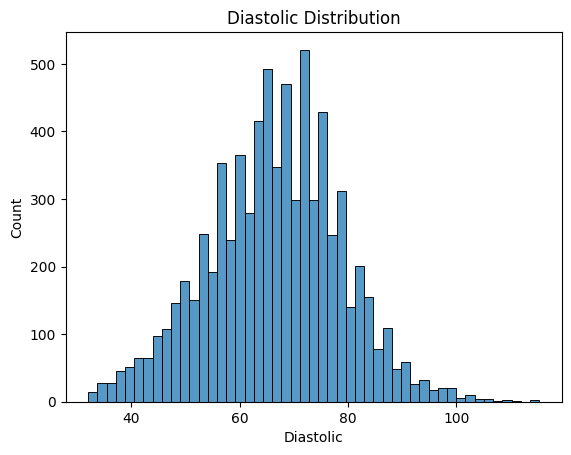

In [16]:
sns.histplot(data=df_eda, x='Diastolic')
plt.title('Diastolic Distribution')

Text(0.5, 1.0, 'Systolic Distribution')

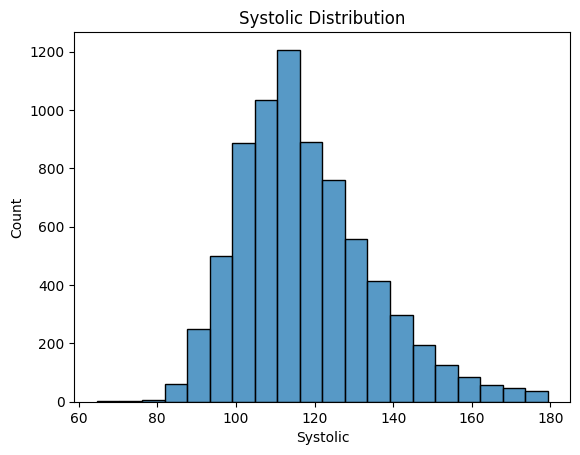

In [17]:
sns.histplot(data=df_eda, x='Systolic', bins=20)
plt.title('Systolic Distribution')

From the Diastolic Distribution and Systolic Distribution we can see that the distributions of blood pressure resemble a normal one.

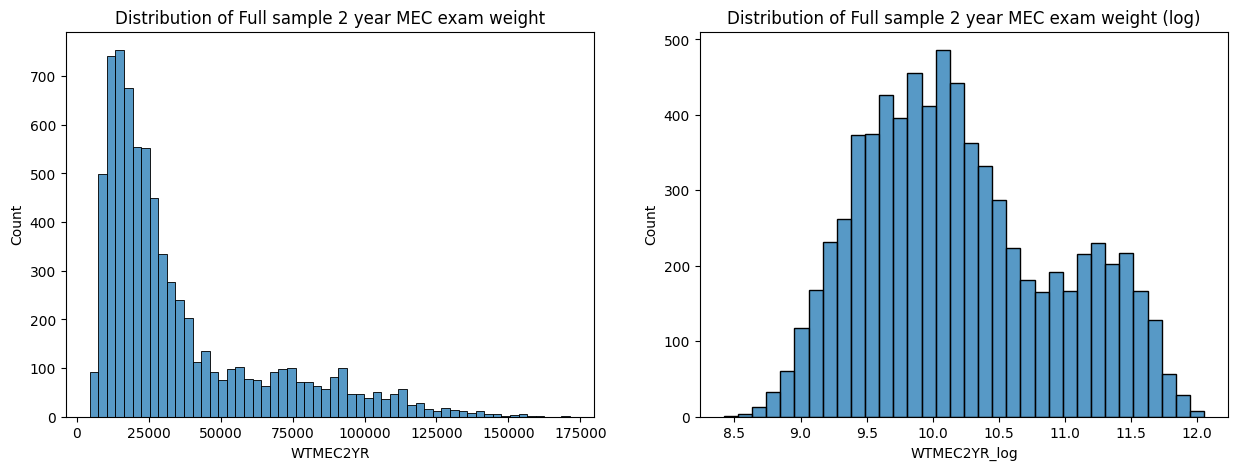

In [18]:
df_eda['WTMEC2YR_log'] = np.log(df_eda['WTMEC2YR'])
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_eda['WTMEC2YR'])
plt.title('Distribution of Full sample 2 year MEC exam weight')
plt.subplot(1, 2, 2)
sns.histplot(df_eda['WTMEC2YR_log'])
plt.title('Distribution of Full sample 2 year MEC exam weight (log)')
df_eda.drop(columns=['WTMEC2YR_log'], inplace=True)

WTMEC2YR means Full sample 2 year MEC exam weight. Its distribution is right screwed. After taking log, it becomes more centered. Similarly we can use log to deal with all the weight related features.

In [19]:
for col in ['WTMEC2YR', 'WTINT2YR', 'WTDRD1', 'WTDR2D']:
    df_eda[col+'_log'] = np.log1p(df_eda[col])
    df_eda.drop(columns=[col], inplace=True)

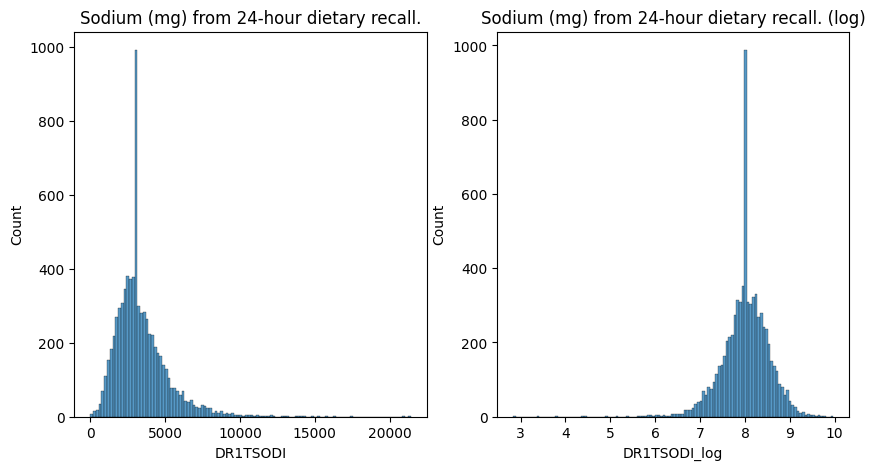

In [20]:
df_eda['DR1TSODI_log'] = np.log(df_eda['DR1TSODI'])
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_eda['DR1TSODI'])
plt.title('Sodium (mg) from 24-hour dietary recall.')
plt.subplot(1, 2, 2)
sns.histplot(df_eda['DR1TSODI_log'])
plt.title('Sodium (mg) from 24-hour dietary recall. (log)')
df_eda.drop(columns=['DR1TSODI_log'], inplace=True)

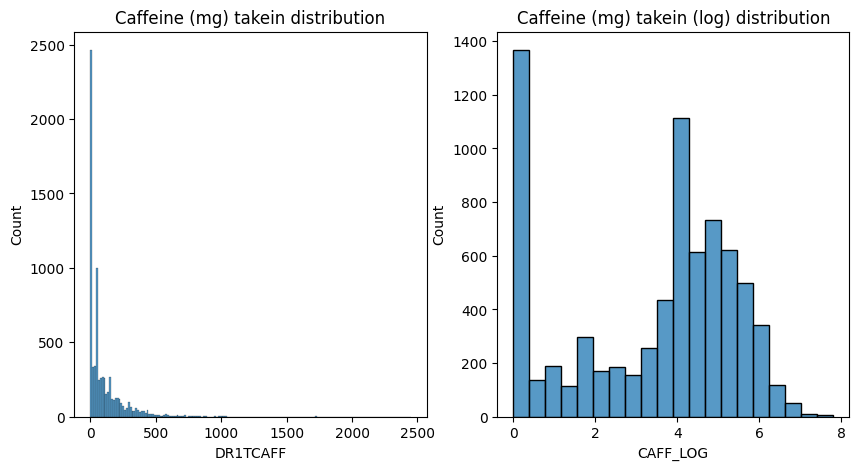

In [21]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(data=df_eda, x='DR1TCAFF')
df_eda['CAFF_LOG'] = np.log1p(df_eda['DR1TCAFF'])
plt.title('Caffeine (mg) takein distribution')
plt.subplot(1, 2, 2)
sns.histplot(data=df_eda, x='CAFF_LOG', bins=20)
plt.title('Caffeine (mg) takein (log) distribution')
df_eda.drop(columns=['CAFF_LOG'], inplace=True)

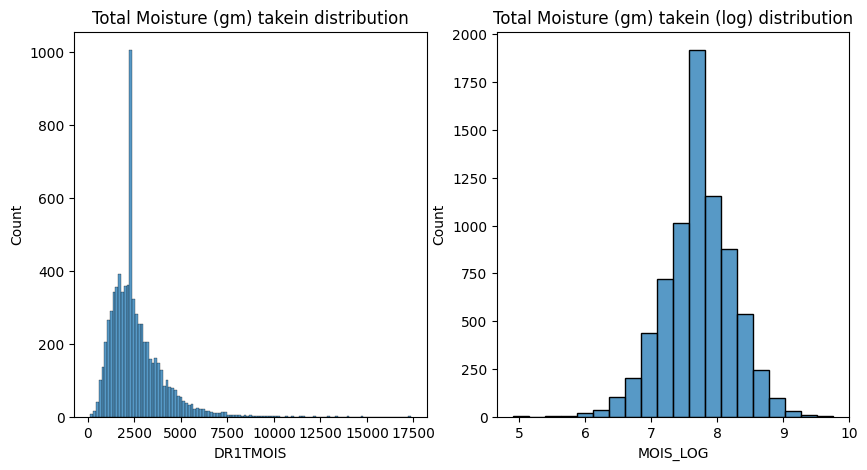

In [22]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(data=df_eda, x='DR1TMOIS')
plt.title('Total Moisture (gm) takein distribution')
df_eda['MOIS_LOG'] = np.log(df_eda['DR1TMOIS'])
plt.subplot(1, 2, 2)
sns.histplot(data=df_eda, x='MOIS_LOG', bins=20)
plt.title('Total Moisture (gm) takein (log) distribution')
df_eda.drop(columns=['MOIS_LOG'], inplace=True)

It can be seen that most of the right-screwing features in diet dataset can be processed with log.

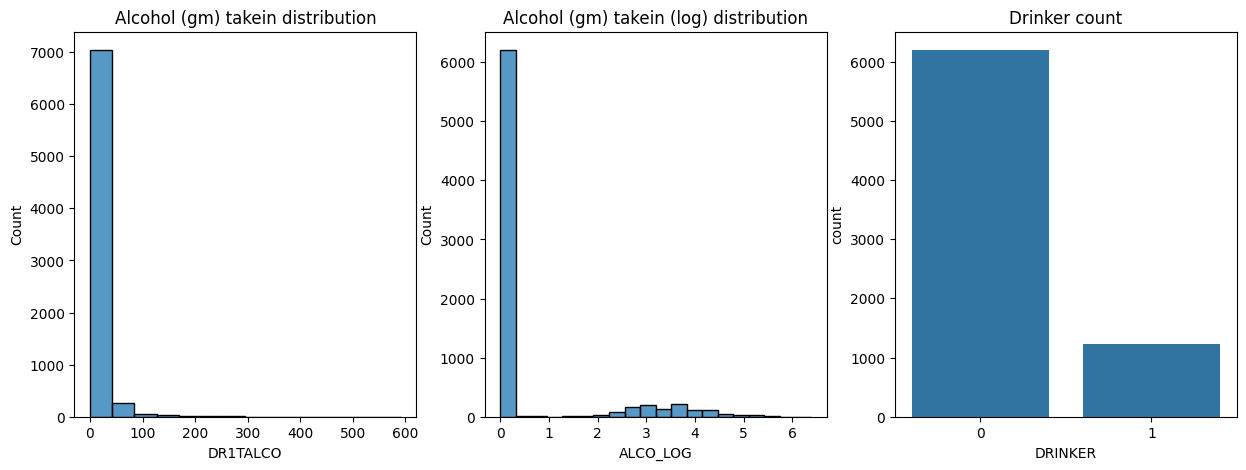

In [23]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(data=df_eda, x='DR1TALCO')
plt.title('Alcohol (gm) takein distribution')

plt.subplot(1, 3, 2)
df_eda['ALCO_LOG'] = np.log(df_eda['DR1TALCO']+1)
sns.histplot(data=df_eda, x='ALCO_LOG', bins=20)
plt.title('Alcohol (gm) takein (log) distribution')
df_eda.drop(columns=['ALCO_LOG'], inplace=True)

plt.subplot(1, 3, 3)
df_eda['DRINKER'] = np.where(df_eda['DR1TALCO'] > 0, 1, 0)
sns.countplot(data=df_eda, x='DRINKER')
plt.title('Drinker count')
df_eda.drop(columns=['DRINKER'], inplace=True)

After observation of several features in diet, we find that most of the features are severely screwed. We can divide the features into two kinds. Kind 1 feature can be processed by taking log, and kind 2 features with number of 0 exceeding the half can be processed by binarize.

In [24]:
from sklearn.preprocessing import FunctionTransformer
log_transform = FunctionTransformer(np.log1p)
# drop columns with unclear meaning or irrelevant meaning
df_eda.drop(columns=['DR1HELPD'], inplace=True)

# scaling
object_cols = df_eda.select_dtypes(include='object').columns.to_list()
for column in df_eda.columns:
    if column.startswith('DR1') and column not in object_cols:
        if len(df_eda[df_eda[column] == 0]) > 3500:
            df_eda[column+'_bin'] = np.where(df_eda[column] == 0, 0, 1)
        else:
            df_eda[column +
                   '_log'] = log_transform.fit_transform(df_eda[[column]])
        df_eda.drop(columns=[column], inplace=True)

df_eda.describe().T

count        mean        std         min         25%  \
Diastolic     7417.0   66.418678  12.323763   32.000000   58.000000   
Systolic      7417.0  117.846074  16.978881   64.666667  106.000000   
MGQ070        7417.0    1.883781   0.374810    1.000000    2.000000   
BPAEN2        7417.0    1.953620   0.210321    1.000000    2.000000   
OHDDESTS      7417.0    1.091951   0.418570    1.000000    1.000000   
MGDEXSTS      7417.0    1.111770   0.441927    1.000000    1.000000   
MGDCGSZ       7417.0   65.609370  22.827261    8.000000   50.100000   
BMXHT         7417.0  164.051626  12.755969  113.000000  156.900000   
BMXWAIST      7417.0   92.880289  18.733289   47.800000   79.800000   
BPAEN3        7417.0    1.963058   0.188633    1.000000    2.000000   
MGXH1AVE      7417.0   30.878340  10.970822    4.000000   23.266667   
MGXH2AVE      7417.0   31.338147  11.215776    4.000000   23.600000   
BMXLEG        7417.0   38.628340   3.943522   24.400000   36.200000   
BPXPULS       7417.0    1.016179   0.126172    1.000000    1.000000   
MGQ100        7417.0    1.909532   0.368365    1.000000    2.000000   
BPXPLS        7417.0   74.374815  12.327898   40.000000   66.000000   
BMXARML       7417.0   36.315545   3.521626   22.700000   34.400000   
BMXWT         7417.0   74.492423  24.639177   16.900000   58.500000   
BMXARMC       7417.0   31.316880   5.992406   14.600000   27.400000   
BMDAVSAD      7417.0   21.100917   4.782998   10.100000   17.600000   
BPACSZ        7417.0    3.679385   0.784627    1.000000    3.000000   
BMXBMI        7417.0   27.223311   7.422467   12.300000   22.000000   
OHDEXSTS      7417.0    1.133747   0.455596    1.000000    1.000000   
RIDAGEYR      7417.0   38.767561  21.848766    8.000000   18.000000   
DMDHRAGE      7417.0   48.423082  15.564912   18.000000   37.000000   
INDFMPIR      7417.0    2.330477   1.584662    0.000000    1.020000   
WTMEC2YR_log  7417.0   10.210559   0.731725    8.419461    9.649359   
WTINT2YR_log  7417.0   10.179140   0.731922    8.422082    9.621213   
WTDRD1_log    7417.0   10.209753   0.846454    7.893617    9.628437   
WTDR2D_log    7417.0    9.110337   3.232466    0.000000    9.176598   
DR1TSODI_log  7417.0    8.015418   0.511070    2.890372    7.751905   
DR1TCAFF_log  7417.0    3.364622   2.057916    0.000000    1.609438   
DR1TPOTA_log  7417.0    7.697898   0.498960    4.234107    7.441907   
DR1TVB6_log   7417.0    1.024997   0.383094    0.015873    0.786638   
DR1TMOIS_log  7417.0    7.729477   0.517390    4.919616    7.423604   
DR1TMAGN_log  7417.0    5.526133   0.494213    0.000000    5.252273   
DR1TP204_log  7417.0    0.135262   0.106309    0.000000    0.061095   
DR1TCALC_log  7417.0    6.662570   0.624949    1.945910    6.320768   
DR1TLZ_log    7417.0    6.449190   1.198493    0.000000    5.802118   
DR1TFF_log    7417.0    5.140112   0.644941    0.000000    4.804021   
DR1TCHL_log   7417.0    5.589702   0.607499    0.000000    5.246498   
DR1MNRSP_log  7417.0    0.719498   0.152579    0.693147    0.693147   
DR1TPROT_log  7417.0    4.260708   0.524118    0.000000    3.982481   
DR1TCOPP_log  7417.0    0.722991   0.260665    0.021761    0.555608   
DR1TM161_log  7417.0    0.653290   0.320698    0.000000    0.427227   
DR1TP225_log  7417.0    0.022214   0.031138    0.000000    0.007968   
DR1TALCO_bin  7417.0    0.164622   0.370864    0.000000    0.000000   
DR1TVK_log    7417.0    4.197323   0.927531    0.000000    3.673766   
DR1TCHOL_log  7417.0    5.321091   0.886413    0.000000    4.882802   
DR1TP226_log  7417.0    0.047966   0.114558    0.000000    0.002996   
DR1.330Z_bin  7417.0    0.438722   0.496264    0.000000    0.000000   
DR1TSELE_log  7417.0    4.587971   0.563138    0.000000    4.304065   
DR1TP205_log  7417.0    0.024484   0.071921    0.000000    0.002996   
DR1.320Z_log  7417.0    5.512891   2.721796    0.000000    5.484797   
DR1TNUMF_log  7417.0    2.728377   0.368098    0.693147    2.484907   
DR1BWATZ_bin  7417.0    0.365781   0.48

Now all the features have a more centralized and balanced distribution.

### 1.2.2 Feature Correlation Inspection

Text(0.5, 1.0, 'Correlation Heatmap')

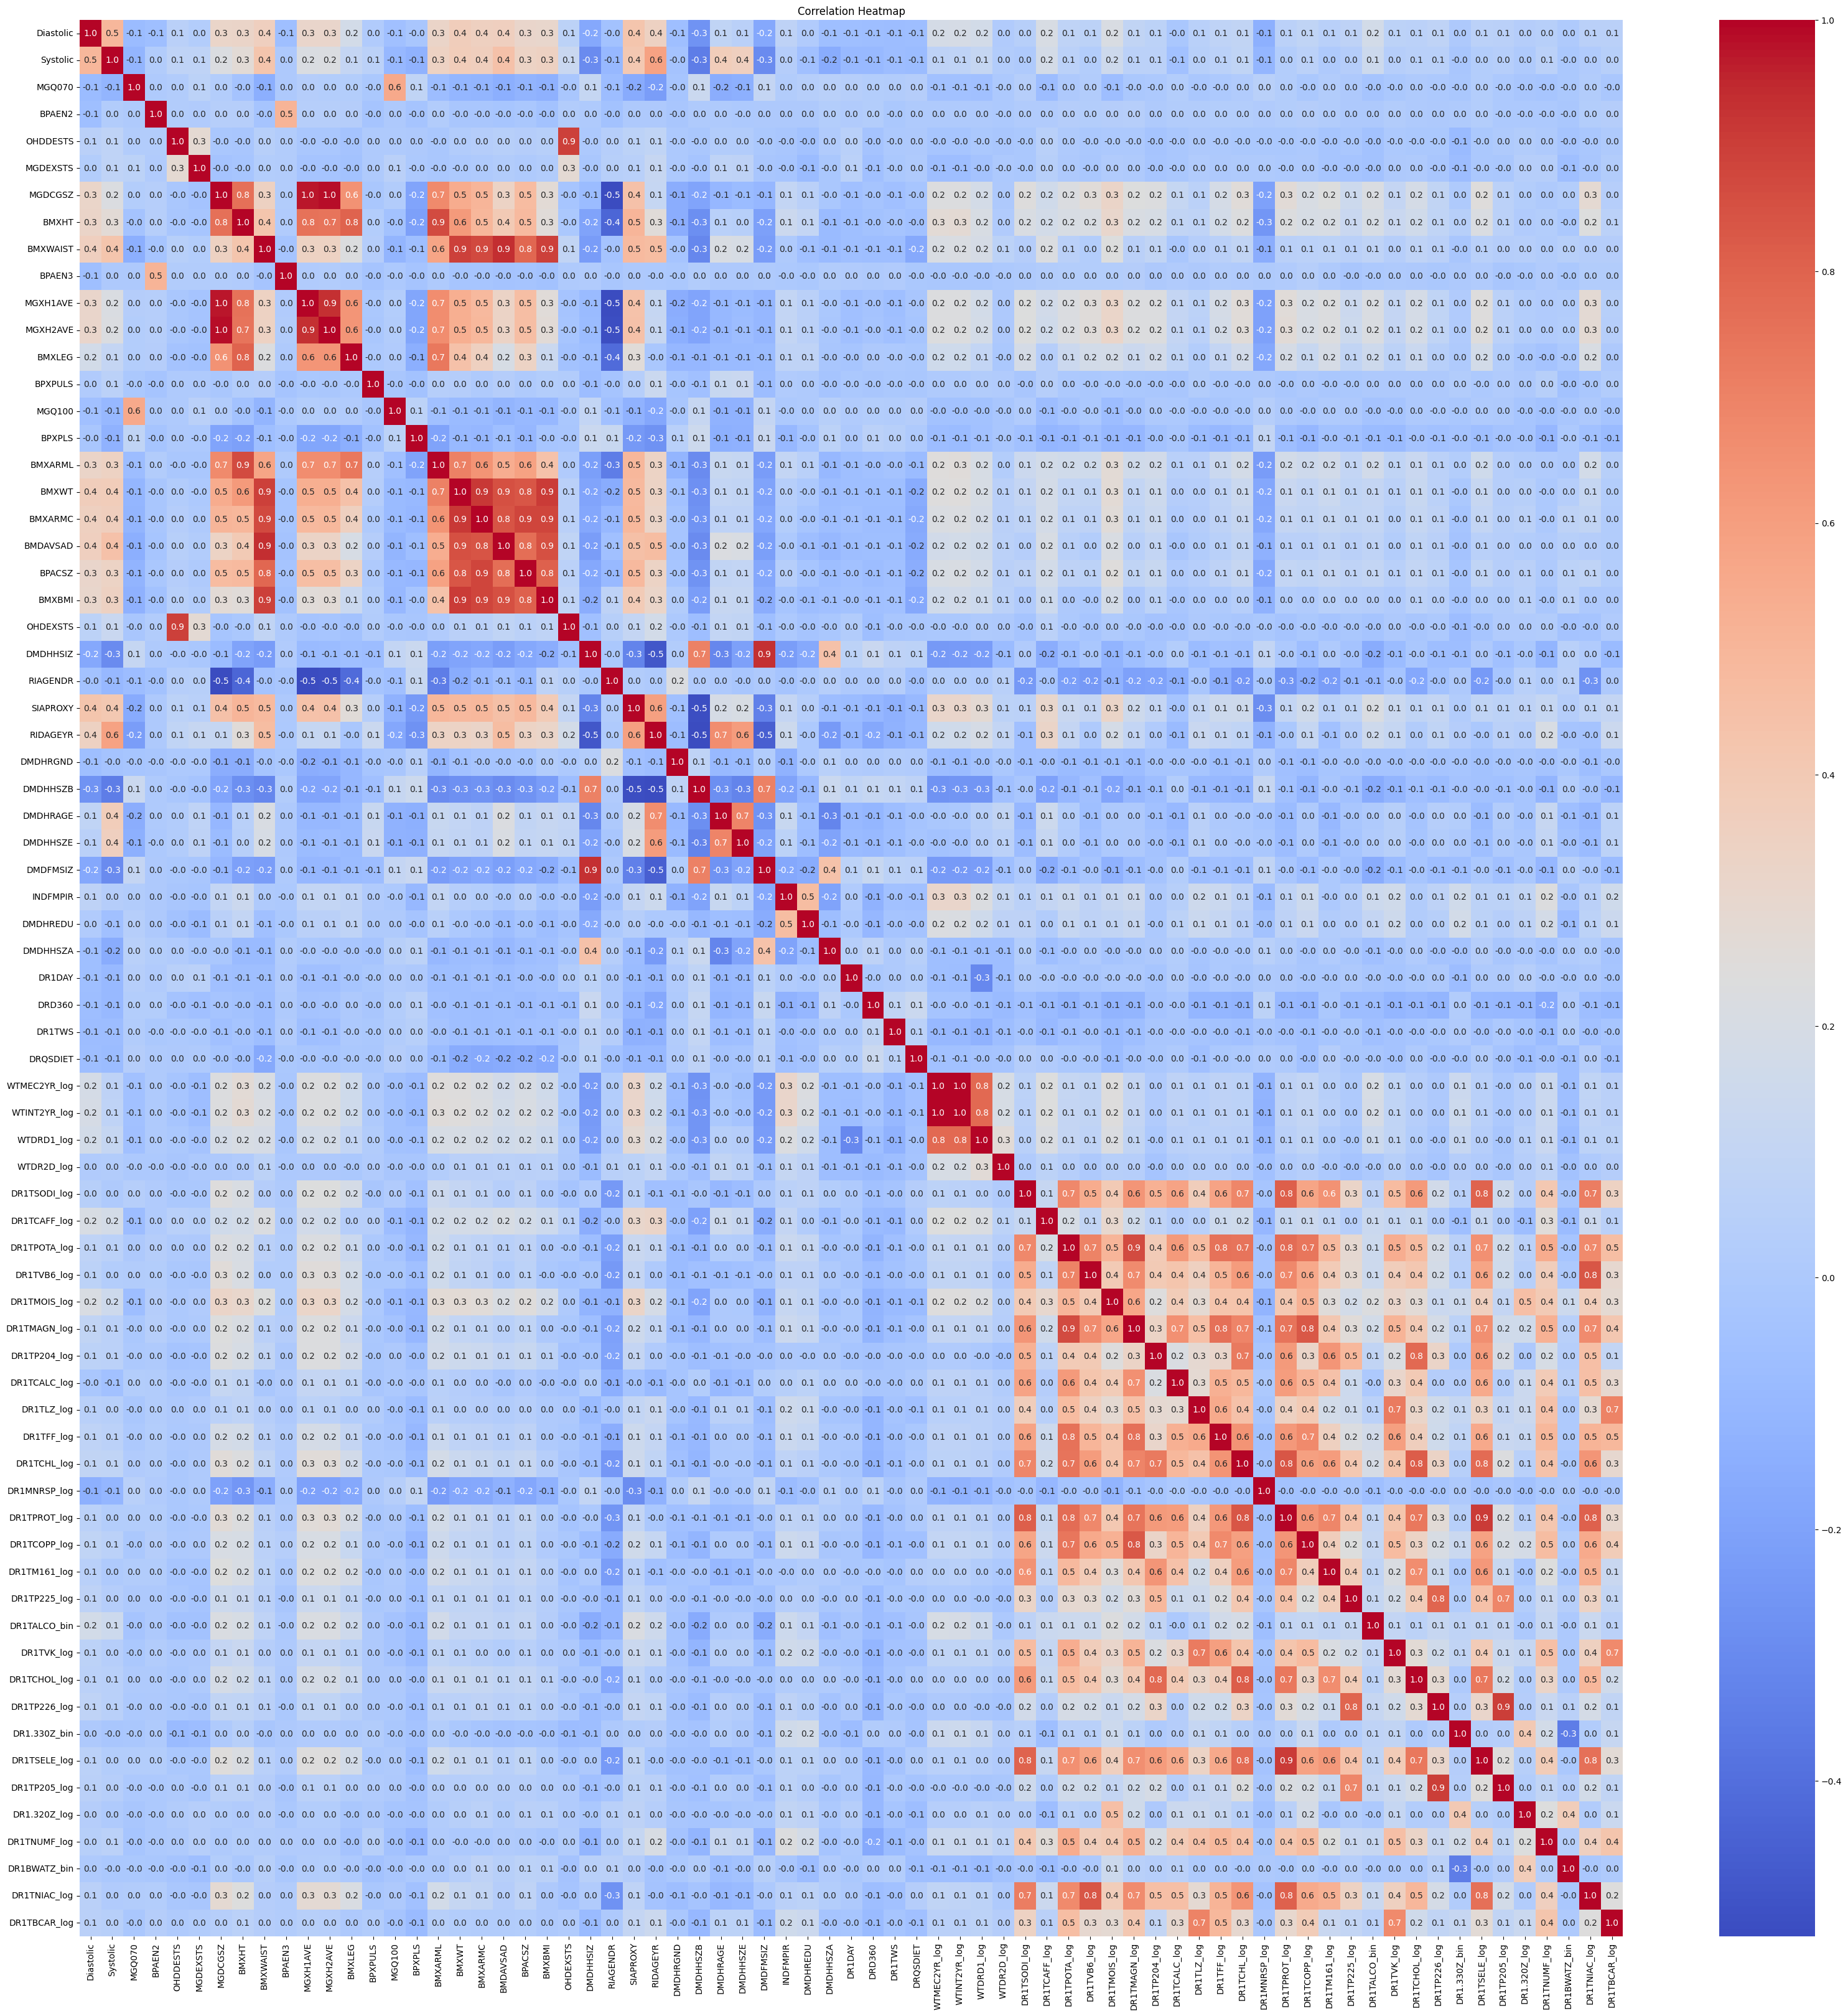

In [25]:
# convert datatype to calculate correlation
for column in df_eda.select_dtypes(include=['object']).columns:
    if column != 'blood_pressure':
        df_eda[column] = df_eda[column].astype('float')

plt.figure(figsize=(40, 40))
sns.heatmap(df_eda.drop(columns=['blood_pressure']).corr(
), cmap='coolwarm', fmt='.1f', annot=True)
plt.title('Correlation Heatmap')

From the data we obtained so far they can be roughly categorized into following classes: personal information, body measurement, diets. It can be seen that considerable self-correlation exists in measurements and diets, which might be caused by the multiple-time measurement method. This indicates a need to drop some highly-correlated values to reduce redundancy.

In [26]:
# Filter out rows where 'var1' is equal to 'var2'
data_corr = df_eda.drop(
    columns=['blood_pressure']).corr().stack().reset_index()
data_corr.columns = ['var1', 'var2', 'corr']
data_corr = data_corr[data_corr['var1'] != data_corr['var2']]
data_corr = data_corr.sort_values(by='corr', ascending=False, key=abs)
data_corr = data_corr.reset_index(drop=True)
data_corr = data_corr.iloc[::2]
data_corr.head(20)

var1          var2      corr
0   WTMEC2YR_log  WTINT2YR_log  0.998422
2        MGDCGSZ      MGXH2AVE  0.982349
4       MGXH1AVE       MGDCGSZ  0.974203
6       BMXWAIST      BMDAVSAD  0.938394
8       MGXH2AVE      MGXH1AVE  0.934328
10      DMDFMSIZ      DMDHHSIZ  0.933495
12       BMXARMC         BMXWT  0.915021
14  DR1TSELE_log  DR1TPROT_log  0.907288
16        BMXBMI         BMXWT  0.906941
18  DR1TP205_log  DR1TP226_log  0.900801
20      OHDEXSTS      OHDDESTS  0.898575
22      BMXWAIST         BMXWT  0.896755
24      BMXWAIST        BMXBMI  0.895418
26       BMXARMC        BMXBMI  0.886118
28        BPACSZ       BMXARMC  0.885148
30      BMXWAIST       BMXARMC  0.871369
32  DR1TMAGN_log  DR1TPOTA_log  0.867873
34         BMXHT       BMXARML  0.865803
36        BMXBMI      BMDAVSAD  0.854559
38         BMXWT      BMDAVSAD  0.852707

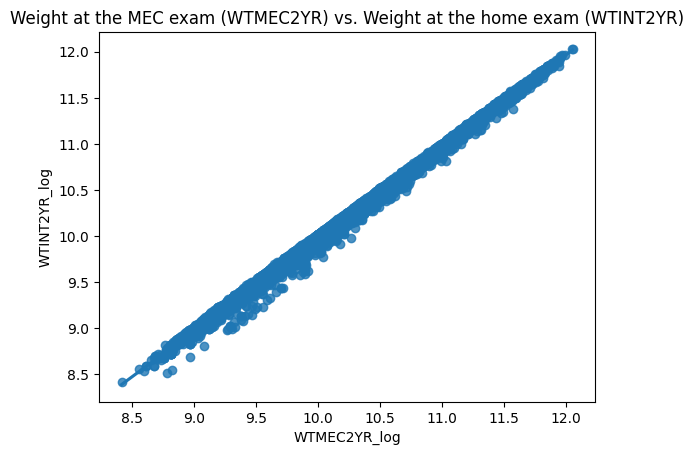

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Q('WTMEC2YR_log')   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.377e+32
Date:                Sun, 24 Mar 2024   Prob (F-statistic):               0.00
Time:                        06:41:08   Log-Likelihood:             2.3319e+05
No. Observations:                7417   AIC:                        -4.664e+05
Df Residuals:                    7415   BIC:                        -4.664e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1.141e-14   8.72e-16     13.079      0.000     9.7e-15    1.31e-14
Q('WTMEC2YR_log')     1.0000   8.52e-17   1.17e+16      0.000       1.000       1.000
==============================================================================
Omnibus:                     1547.785   Durbin-Watson:                   0.110
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              308.122
Skew:                           0.089   Prob(JB):                     1.24e-67
Kurtosis:                       2.018   Cond. No.                         145.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

sns.regplot(data=df_eda, x='WTMEC2YR_log', y='WTINT2YR_log')
plt.title('Weight at the MEC exam (WTMEC2YR) vs. Weight at the home exam (WTINT2YR)')
plt.show()

model = smf.ols("Q('WTMEC2YR_log') ~ Q('WTMEC2YR_log')", data=df_eda).fit()
model.summary()

In [28]:
df_eda.drop(columns=['WTINT2YR_log'], inplace=True)

We conducted a linear regression to test the linear relationship between WTMEC2YR_log and WTINT2YR_log. We set the alpha value as 0.05. As the p-values of the model, the intercpt and the slope are all less than 0.05 and the correlation is large, we conclude that the two features have a strong linear relationship and the regression model is significant, which means that we should select only one feature from them. Since WTMEC2YR means Full sample 2 year MEC exam weight and is more professional, we choose WTMEC2YR_log.

<Figure size 2000x2000 with 0 Axes>

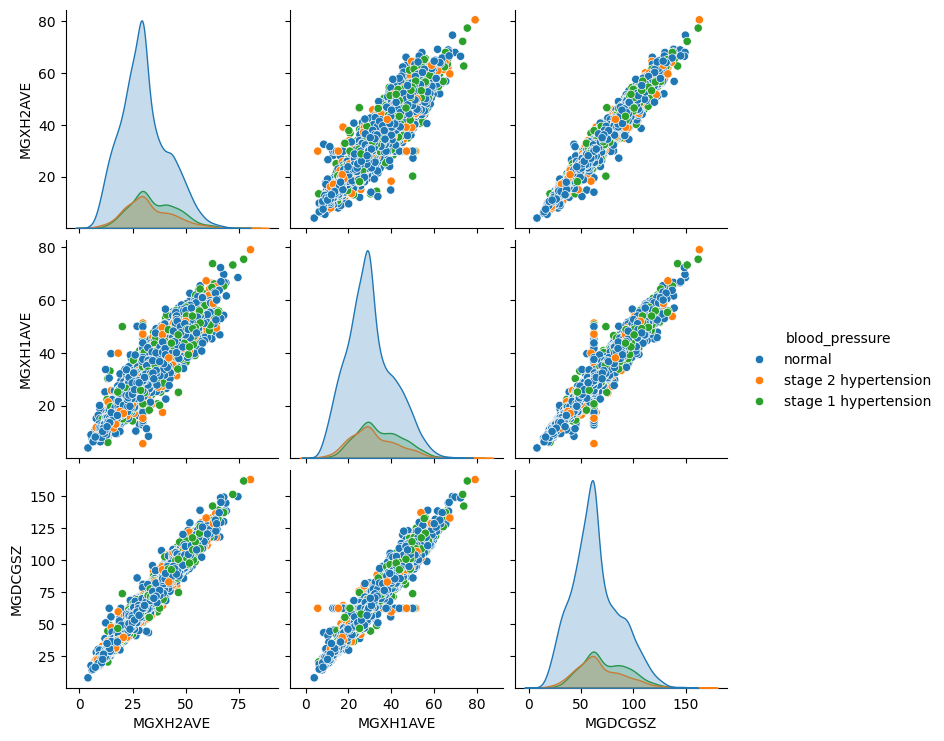

In [29]:
plt.figure(figsize=(20, 20))
sns.pairplot(data=df_eda[['MGXH2AVE', 'MGXH1AVE',
             'MGDCGSZ', 'blood_pressure']], hue='blood_pressure')
plt.show()
df_eda.drop(columns=['MGXH2AVE', 'MGXH1AVE'], inplace=True)

MGXH2AVE means grip strength (kg), hand 2. MGXH1AVE means grip strength (kg), hand 1. MGDCGSZ means combined grip strength (kg): the sum of the largest reading from each hand. Since MGDCGSZ is more conclusive, we choose it and drop the others to reduce redundancy.

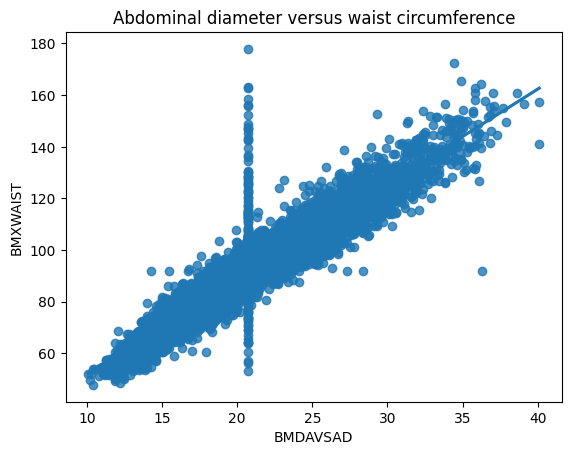

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Q('BMDAVSAD')   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                 5.468e+04
Date:                Sun, 24 Mar 2024   Prob (F-statistic):               0.00
Time:                        06:41:10   Log-Likelihood:                -14251.
No. Observations:                7417   AIC:                         2.851e+04
Df Residuals:                    7415   BIC:                         2.852e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -1.1524      0.097    -11.870      0.000      -1.343      -0.962
Q('BMXWAIST')     0.2396      0.001    233.834      0.000       0.238       0.242
==============================================================================
Omnibus:                     3533.379   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           108354.301
Skew:                          -1.675   Prob(JB):                         0.00
Kurtosis:                      21.423   Cond. No.                         479.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
sns.regplot(data=df_eda, x='BMDAVSAD', y='BMXWAIST')
plt.title('Abdominal diameter versus waist circumference')
plt.show()

model = smf.ols("Q('BMDAVSAD') ~ Q('BMXWAIST')", data=df_eda).fit()
model.summary()

In [31]:
df_eda.drop(columns=['BMDAVSAD'], inplace=True)

We conducted a linear regression to test the linear relationship between BMDAVSAD and BMXWAIST. We set the alpha value as 0.05. As the p-values of the model, the intercpt and the slope are all less than 0.05 and correlation is large, we conclude that the two features have a strong linear relationship and the regression model is significant, which means that we should select only one feature from them. BMXWAIST means waist Circumference (cm), which is more commonly used, and it can be seen from the scatter plot that considerable data in BMDAVSAD is filled, thus we choose BMXWAIST.

In [32]:
df_eda.drop(columns=['DMDFMSIZ'], inplace=True)

DMDHHSIZ means total number of people in the Household, and DMDFMSIZ means total number of people in the Family. Since people is the household is more related to people's daily life, we choose DMDHHSIZ.

For further reduction of the redundancy, we might consider using select-k-best to make the model more orthogonal.

### 1.2.3 Label correlation inspection

In [33]:
label_corr = df_eda.drop(columns=['blood_pressure']).corr()[
    ['Diastolic', 'Systolic']].sort_values(by=['Diastolic', 'Systolic'], ascending=False, key=abs)


label_corr = label_corr.iloc[2:]


display(label_corr)

Diastolic  Systolic
SIAPROXY       0.426202  0.405201
BMXWT          0.371121  0.377512
BMXWAIST       0.360560  0.422752
BMXARMC        0.351315  0.364831
RIDAGEYR       0.350092  0.585382
...                 ...       ...
DMDHREDU       0.016243 -0.053813
WTDR2D_log     0.016133  0.023246
BPXPULS        0.012293  0.063163
DR1BWATZ_bin   0.009892 -0.008333
DR1.330Z_bin   0.003336 -0.020833

[64 rows x 2 columns]

chi^2 =  575.4782165355456
p-val =  1.0876597355762779e-125
degree of freedom =  2


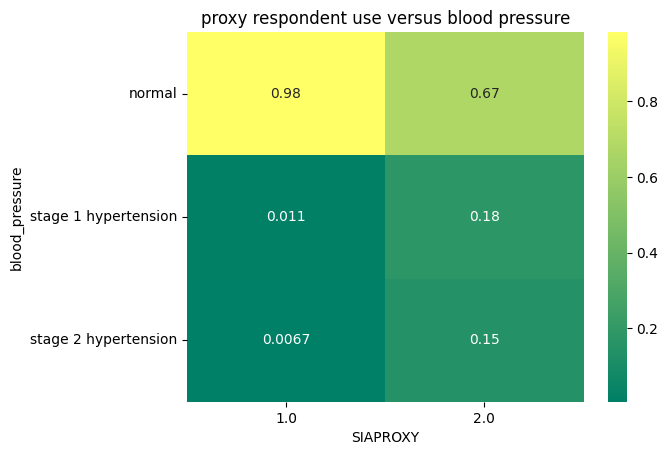

In [34]:
from scipy.stats import chi2_contingency
ct = pd.crosstab(df_eda['blood_pressure'],
                 df_eda['SIAPROXY'], normalize='columns')
plt.title('proxy respondent use versus blood pressure')
sns.heatmap(ct, cmap='summer', annot=True)
ct_chi2 = pd.crosstab(df_eda['blood_pressure'], df_eda['SIAPROXY'])
chi2, p, dof, expected = chi2_contingency(ct_chi2)

print("chi^2 = ", chi2)
print("p-val = ", p)
print("degree of freedom = ", dof)

SIAPROXY refers to whether a proxy respondent was used in conducting the Sample Person (SP) interview. Although it is not directly related to blood pressure, it still indicates some bias caused in the process of sampling, which means that the feature should be considered for a more balanced model. We also conducted a Chi2 test and setted the alpha value to 0.05. Since the p-value is less than 0.05, we conclude that the use of proxy respondent is correlated to blood pressure. From the proportion it also sugest that people without the use of proxy respondent is more likely to have a noraml blood pressure.

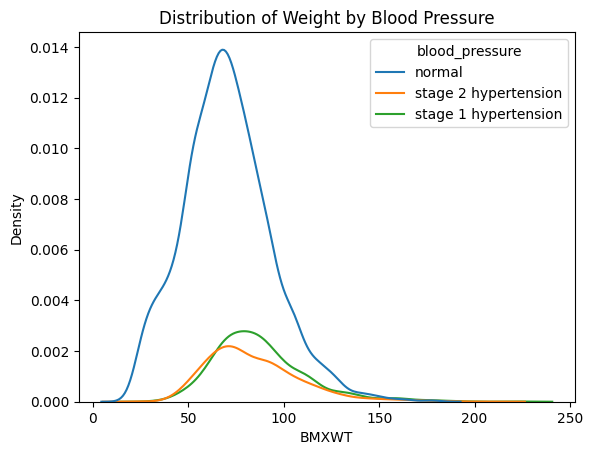

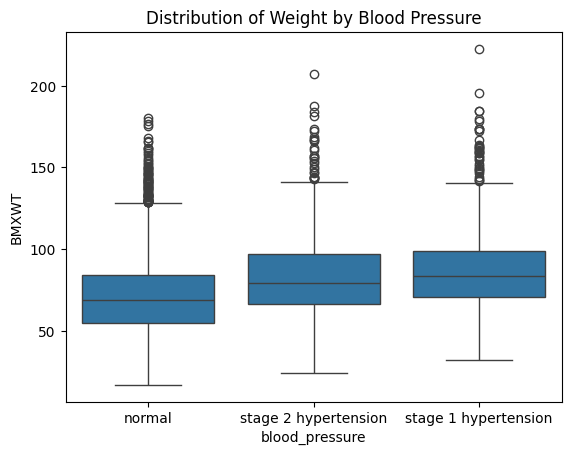

                      sum_sq      df           F         PR(>F)
blood_pressure  3.497763e+05     2.0  312.258464  6.276902e-131
Residual        4.152396e+06  7414.0         NaN            NaN


<class 'statsmodels.iolib.table.SimpleTable'>

In [35]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm

sns.kdeplot(data=df_eda, x='BMXWT', hue='blood_pressure')
plt.title('Distribution of Weight by Blood Pressure')
plt.show()
sns.boxplot(data=df_eda, y='BMXWT', x='blood_pressure')
plt.title('Distribution of Weight by Blood Pressure')
plt.show()

lm = smf.ols('BMXWT ~ blood_pressure', data=df_eda).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

tukey = pairwise_tukeyhsd(
    endog=df_eda['BMXWT'], groups=df_eda['blood_pressure'], alpha=0.05)
tukey.summary()

BMXWT means the weight. The kde plot and the box plot all show the difference of the distribution of weight under different blood pressure categories. We also conducted an ANOVA test and set 0.05 as alpha value. Since the p-value of ANOVA test is less than 0.05, we conclude that the difference of the distribution of weight under different blood pressure categories is significant. A Tukey HSD test was also conducted the see the different between blood pressure categories, and alpha is set to 0.05. From the p value we conclude that all pairs show significant difference in weight distribution. It seems that people with greater weight are more likely to be hypertension.

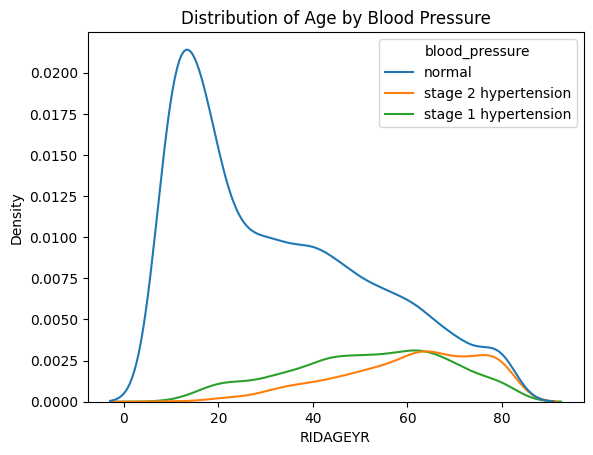

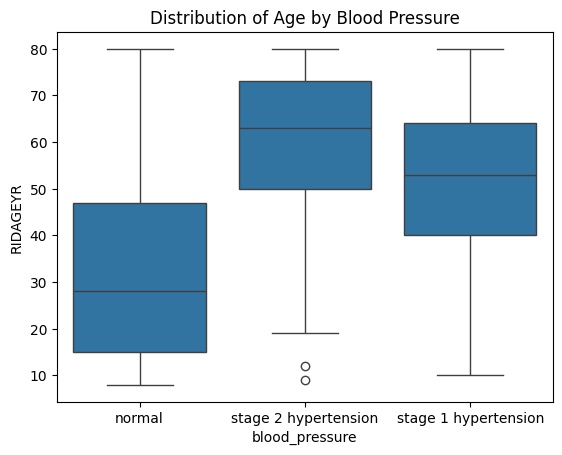

                      sum_sq      df           F  PR(>F)
blood_pressure  7.814943e+05     2.0  1050.14315     0.0
Residual        2.758671e+06  7414.0         NaN     NaN


<class 'statsmodels.iolib.table.SimpleTable'>

In [36]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

sns.kdeplot(data=df_eda, x='RIDAGEYR', hue='blood_pressure')
plt.title('Distribution of Age by Blood Pressure')
plt.show()
sns.boxplot(data=df_eda, y='RIDAGEYR', x='blood_pressure')
plt.title('Distribution of Age by Blood Pressure')
plt.show()

lm = smf.ols('RIDAGEYR ~ blood_pressure', data=df_eda).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

tukey = pairwise_tukeyhsd(
    endog=df_eda['RIDAGEYR'], groups=df_eda['blood_pressure'], alpha=0.05)
tukey.summary()

RIDAGEYR means the age. The kde plot and the box plot all show the difference of the distribution of agw under different blood pressure categories. We also conducted an ANOVA test and set 0.05 as alpha value. Since the p-value of ANOVA test is less than 0.05, we conclude that the difference of the distribution of age under different blood pressure categories is significant. A Tukey HSD test was also conducted the see the different between blood pressure categories, and alpha is set to 0.05. From the p value we conclude that all pairs show significant difference in age distribution. It seems that people with greater age are more likely to be hypertension.

chi^2 =  602.1607205286937
p-val =  8.029554646353272e-125
degree of freedom =  8


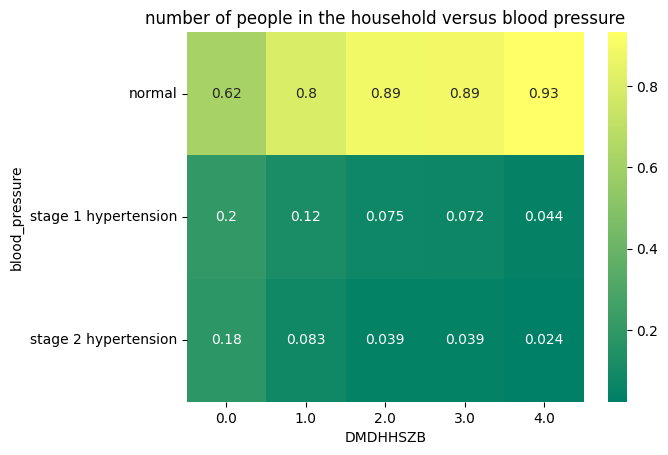

In [37]:
from scipy.stats import chi2_contingency
ct = pd.crosstab(df_eda['blood_pressure'],
                 df_eda['DMDHHSZB'], normalize='columns')
plt.title('number of people in the household versus blood pressure')
sns.heatmap(ct, cmap='summer', annot=True)
ct_chi2 = pd.crosstab(df_eda['blood_pressure'], df_eda['DMDHHSZB'])
chi2, p, dof, expected = chi2_contingency(ct_chi2)

print("chi^2 = ", chi2)
print("p-val = ", p)
print("degree of freedom = ", dof)

DMDHHSZB refers to number of children aged 6-17 years old in the household. A Chi2 test was conducted with alpha value of 0.05. Since the p value is less than 0.05, and the pearson correlation is negative, we conclude that the number of children aged 6-17 years old in the household is negatively correlated with blood pressure. The proportion suggests that people with more children aged 6-17 years old in the household is more likely to have normal blood pressure.

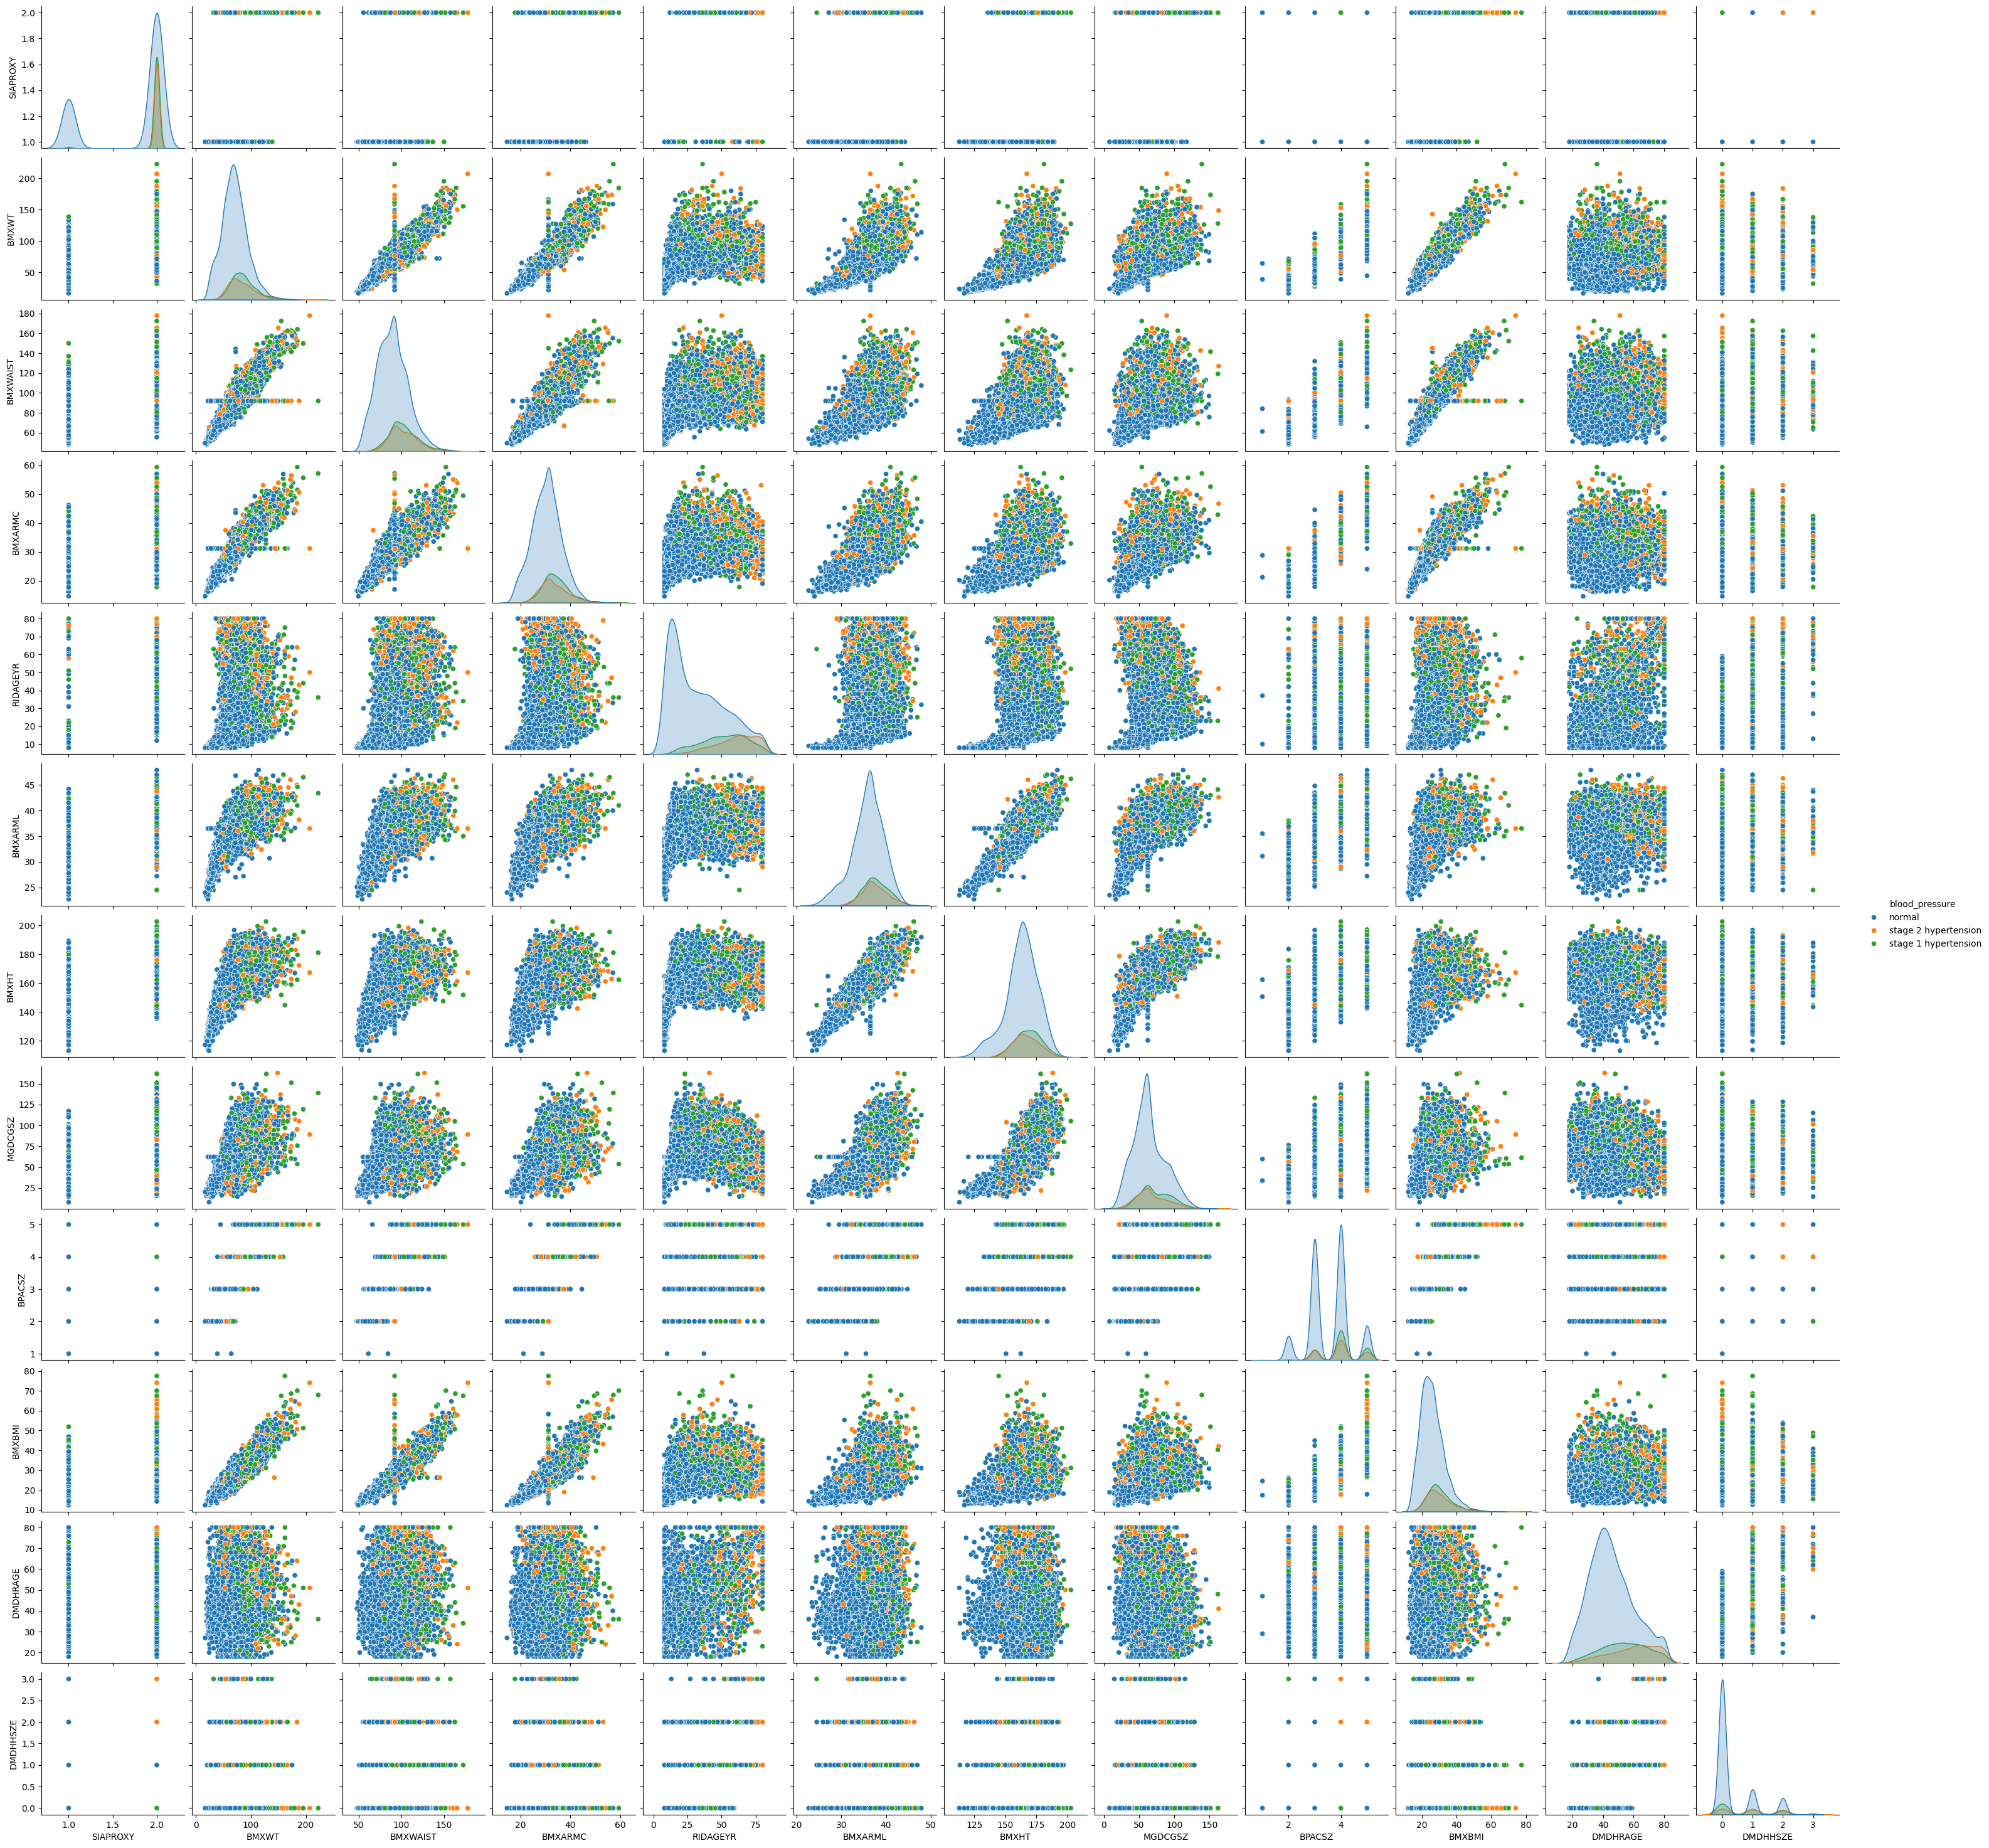

In [38]:
high_cols = label_corr[(label_corr['Diastolic'] > 0.25) | (
    label_corr['Systolic'] > 0.25)].index.to_list()


sns.pairplot(data=df_eda[high_cols+['blood_pressure']], hue='blood_pressure')

The pair plot showes an overall correlation between the features and the blood pressure. It can be seen that the divisions of blood pressure categories in the distributions are distinct, verifying the validness of the features selected.

## 2. Modeling

### 2.1 Preprocess

In [39]:
# define a function transformer to process the data according to the EDA
from sklearn.preprocessing import FunctionTransformer
log_transform = FunctionTransformer(np.log1p)


def eda_transform(data):
    df_eda = data.copy()
    for col in ['WTMEC2YR', 'WTINT2YR', 'WTDRD1', 'WTDR2D']:
        df_eda[col+'_log'] = np.log1p(df_eda[col])
        df_eda.drop(columns=[col], inplace=True)
    from sklearn.preprocessing import FunctionTransformer
    object_cols = df_eda.select_dtypes(include='object').columns.to_list()
    for column in df_eda.columns:
        if column.startswith('DR1') and column not in object_cols:
            if len(df_eda[df_eda[column] == 0]) > 3500:
                df_eda[column+'_bin'] = np.where(df_eda[column] == 0, 0, 1)
            else:
                df_eda[column +
                       '_log'] = log_transform.fit_transform(df_eda[[column]])
                df_eda.drop(columns=[column], inplace=True)
    df_eda.drop(columns=['WTINT2YR_log', 'MGXH2AVE', 'MGXH1AVE',
                'BMDAVSAD', 'DMDFMSIZ', 'SIAPROXY'], inplace=True)
    return df_eda


eda_transformer = FunctionTransformer(eda_transform)

### 2.2 Pipline

In [40]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import chi2, f_regression, f_classif

binary_map = {
    'normal': 0,
    'elevated': 0,
    'stage 1 hypertension': 1,
    'stage 2 hypertension': 1
}

X = df_bp.drop(columns=['SEQN', 'blood_pressure', 'Diastolic', 'Systolic'])
y = df_bp['blood_pressure'].map(binary_map)

X = eda_transformer.fit_transform(X)
numerical = []
categorical = []
for column in X.columns:
    if X[column].nunique() > 10:
        numerical.append(column)
    else:
        categorical.append(column)
print(categorical)
print(numerical)
print(len(categorical+numerical))

preproc = ColumnTransformer([
    ('std', StandardScaler(), numerical),
    ('ohe', OneHotEncoder(drop='first'), categorical)
], remainder='drop')

rfc = Pipeline([
    ('preproc', preproc),
    ('select', SelectKBest(f_classif, k=45)),
    ('classify', RandomForestClassifier(n_estimators=600,
     max_depth=10, max_features=20, random_state=42))
])

hgb = Pipeline([
    ('preproc', preproc),
    ('select', SelectKBest(f_classif, k=35)),
    ('classify', HistGradientBoostingClassifier(
        learning_rate=0.1, random_state=42, max_depth=2, max_iter=100))
])

mlp = Pipeline([
    ('preproc', preproc),
    ('mlpc', MLPClassifier(hidden_layer_sizes=(32),
     activation='logistic', solver='adam', max_iter=1000, random_state=42, alpha=0.001))
])

voting = VotingClassifier(estimators=[
    ('rfc', rfc),
    ('hgb', hgb),
    ('mlp', mlp),
], voting='soft', weights=[0.7, 0.3, 0])

['MGQ070', 'BPAEN2', 'OHDDESTS', 'MGDEXSTS', 'BPAEN3', 'BPXPULS', 'MGQ100', 'BPACSZ', 'OHDEXSTS', 'DMDHHSIZ', 'RIAGENDR', 'DMDHRGND', 'DMDHHSZB', 'DMDHHSZE', 'DMDHREDU', 'DMDHHSZA', 'DR1DAY', 'DRD360', 'DR1TWS', 'DRQSDIET', 'DR1TALCO_bin', 'DR1.330Z_bin', 'DR1BWATZ_bin']
['MGDCGSZ', 'BMXHT', 'BMXWAIST', 'BMXLEG', 'PEASCTM1', 'BPXPLS', 'BMXARML', 'BMXWT', 'BMXARMC', 'BMXBMI', 'BPXML1', 'RIDAGEYR', 'DMDHRAGE', 'INDFMPIR', 'DR1TALCO', 'DR1.330Z', 'DR1BWATZ', 'WTMEC2YR_log', 'WTDRD1_log', 'WTDR2D_log', 'DR1TSODI_log', 'DR1TCAFF_log', 'DR1TPOTA_log', 'DR1TVB6_log', 'DR1TMOIS_log', 'DR1TMAGN_log', 'DR1TP204_log', 'DR1TCALC_log', 'DR1TLZ_log', 'DR1TFF_log', 'DR1TCHL_log', 'DR1MNRSP_log', 'DR1TPROT_log', 'DR1TCOPP_log', 'DR1TM161_log', 'DR1TP225_log', 'DR1HELPD_log', 'DR1TVK_log', 'DR1TCHOL_log', 'DR1TP226_log', 'DR1TSELE_log', 'DR1TP205_log', 'DR1.320Z_log', 'DR1TNUMF_log', 'DR1TNIAC_log', 'DR1TBCAR_log']
69


### 2.3 Parameter optimization

In [41]:
GridSearchCV(rfc, param_grid={
    'select__k': [45, 50, 55],
    'classify__n_estimators': [400, 500, 600],
    'classify__max_depth': [10, 15, 20],
    'classify__max_features': [10, 15, 20]
}, cv=5, scoring='accuracy').fit(X, y).best_params_

{'classify__max_depth': 10,
 'classify__max_features': 20,
 'classify__n_estimators': 600,
 'select__k': 45}

In [42]:
GridSearchCV(hgb, param_grid={
    'select__k': [35],
    'classify__learning_rate': [0.05, 0.1, 0.15],
    'classify__max_depth': [1,2, 3, 4],
    'classify__max_iter': [50, 100, 200]
}, cv=5, scoring='accuracy').fit(X, y).best_params_

{'classify__learning_rate': 0.1,
 'classify__max_depth': 2,
 'classify__max_iter': 100,
 'select__k': 35}

In [43]:
GridSearchCV(mlp, param_grid={
    "mlpc__hidden_layer_sizes": [(32,), (64, 32), (64, 32, 16)],
    "mlpc__activation": ['relu','logistic'],
    "mlpc__solver": ['adam'],
    "mlpc__max_iter": [1000, 1500],
    "mlpc__alpha": [0.0001, 0.001, 0.01]
}, cv=5, scoring='accuracy').fit(X, y).best_params_

{'mlpc__activation': 'logistic',
 'mlpc__alpha': 0.001,
 'mlpc__hidden_layer_sizes': (32,),
 'mlpc__max_iter': 1000,
 'mlpc__solver': 'adam'}

### 2.4 Model training

In [44]:
final_model = hgb.fit(X, y)

## 3 Evaluation

### 3.1 Cross validation

In [45]:
cross_val_score(voting, X, y, cv=10, scoring='accuracy').mean()

0.89011461891303

### 3.2 Confusion matrix

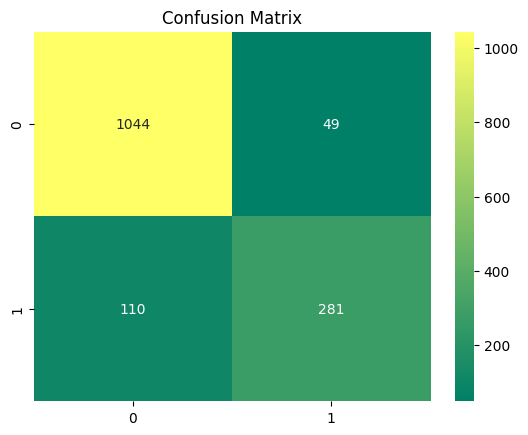

In [46]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)
eva_model = voting.fit(X_train, y_train)
confuse = confusion_matrix(y_test, eva_model.predict(X_test))
sns.heatmap(confuse, cmap='summer', annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

The confusion matrix suggests that our model can effectively classify normal blood pressure and stage 2 hypertension. Its ability to identify stage 1 hypertension is weaker, possibily due to the very limited threshold difference of hypertension judgement.